<a href="https://colab.research.google.com/github/nihal-rao/RL-DQN/blob/master/cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Solving Cartpole v0 using Double Q Networks**




# Importing packages , using tensorflow 2

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
import os
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym import wrappers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler
import math
from agent import Agent     #Importing the Agent class from agent.py

# Training the Agent

In [0]:
env = gym.make('CartPole-v0')					
num_states = env.observation_space.shape[0]  #no. of state features  
num_actions = env.action_space.n 	#dimensionality of action space
lr,gamma = 0.001, 0.99	#learning rate and discount factor
agent = Agent(num_states, num_actions, lr, gamma)
agent.epsilon = 0.5		#initial probabibility of agent choosing random action 
agent.tau = 0.1			#soft update factor
decay_factor = 0.99		#decay factor to reduce epsilon
epsilon_min = 0.01		#minimum value of epsilon
learning_start = 500	#minimum number of experiences in replay buffer before training primary model

EPISODES = 400		#maximum no. of training episodes
scores = np.zeros(EPISODES)
for e in range(EPISODES):
	state = env.reset()		#reset environment for new episode
	reward_sum = 0
	done = False
	while not done:
	
		state = np.atleast_2d(state) 
		action = agent.act(state)	#action taken by the agent
		next_state, reward, done, _ = env.step(action)	#next state and reward as a result of action taken
		reward_sum += reward
		exp = {'s':state[0],'a':action,'r':reward,'s1':next_state,'done':done}
		agent.remember(exp)		#adding the experience to the replay buffer
		state = next_state
		
		if len(agent.memory['r']) > learning_start:
			agent.replay()                       #train the primary model
			agent.soft_update_target_network()   #soft update the target model
		if done:
			break
	#Learn & print results
	agent.step=e
	scores[e]=reward_sum	#total reward obtained in an episode, maximum total reward is 200
	agent.epsilon = max(agent.epsilon*decay_factor,epsilon_min)		#reducing epsilon
	if e==0:
		mean = scores[e]
	if e>0:
		mean = np.mean(scores[np.maximum(0,e-100):e])	#calculating rolling average
	if e % 20 == 0:
		print('episode {}, score {}, avg_score_last_100 {}'.format(e,reward_sum,mean))	#displaying info every 20 episodes
	if e>98 and mean > 195:
		print('Cartpole v0 solved after {} steps'.format(e))#cartpole v0 is solved when average reward for last 100 trials is greater than 195 
		break

episode 0, score 13.0, avg_score_last_100 13.0
episode 20, score 11.0, avg_score_last_100 15.8
episode 40, score 12.0, avg_score_last_100 15.75
episode 60, score 29.0, avg_score_last_100 16.166666666666668
episode 80, score 75.0, avg_score_last_100 23.6125
episode 100, score 200.0, avg_score_last_100 49.19
episode 120, score 200.0, avg_score_last_100 86.03
episode 140, score 200.0, avg_score_last_100 122.89
episode 160, score 200.0, avg_score_last_100 159.49
episode 180, score 200.0, avg_score_last_100 190.3
Cartpole v0 solved after 184 steps


# Plotting rewards v episodes

Text(0, 0.5, 'Rewards')

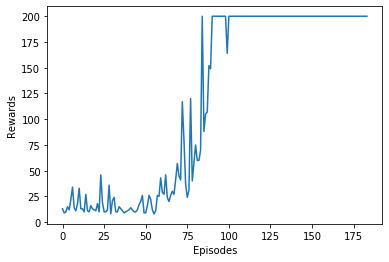

In [0]:
fig,ax = plt.subplots()
ax.plot(np.arange(e) , scores[:e])
ax.set_xlabel('Episodes')
ax.set_ylabel('Rewards')

In [0]:
mov_avg=[]
for i in range(e):
  if i==0:
    mean = scores[0]
  if i>0:
    mean = np.mean(scores[np.maximum(0,i-100):i])
  mov_avg.append(mean)

# Plotting average reward over last 100 episodes  

Text(0, 0.5, 'Rolling Avg for last 100 trials')

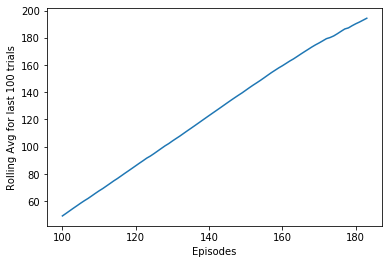

In [0]:
fig,ax = plt.subplots()
ax.plot(np.arange(e)[100:e],mov_avg[100:e])
ax.set_xlabel('Episodes')
ax.set_ylabel('Rolling Avg for last 100 trials')

# Installing dependencies to create video

In [0]:
#@title
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get install x11-utils > /dev/null 2>&1

In [0]:
#@title
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (45.1.0)


In [0]:
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import matplotlib
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay


In [0]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1019'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1019'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# Testing agent and rendering video

In [0]:
env = wrap_env(gym.make("CartPole-v0"))
agent.epsilon=0  #Setting epsilon to zero ie., agent always choose the action which gives maximum Q value.
state = env.reset()
steps = 0
rewards = 0
while True:
  
	env.render()
	state = np.atleast_2d(state) 
	action = agent.act(state) #Taking optimal action for the given state
	next_state, reward, done, _ = env.step(action) #the next state and reward obtained as a result of taking the action
	steps += 1
	rewards += reward 
	state = next_state	
	if done: 
		break
			
env.close()
show_video() #displaying video
print("Testing steps: {} rewards {}: ".format(steps, rewards))

Testing steps: 200 rewards 200.0: 
